# Using CNN to classify between Cat vs Dog

# 1-Importing Dataset

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download karakaggle/kaggle-cat-vs-dog-dataset

Dataset URL: https://www.kaggle.com/datasets/karakaggle/kaggle-cat-vs-dog-dataset
License(s): unknown
 94% 743M/787M [00:04<00:01, 42.9MB/s]
100% 787M/787M [00:04<00:00, 173MB/s] 


In [ ]:
!unzip /content/kaggle-cat-vs-dog-dataset.zip

#2-Data Preprocessing

In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio("/content/kagglecatsanddogs_3367a/PetImages",output="/content/data1",ratio=(0.8,0.2),seed=21)



Copying files: 24961 files [00:04, 5414.62 files/s]


In [ ]:
import os
import tensorflow as tf
from PIL import Image

def delete_completely_invalid_images(folder):
    bad_files = []

    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)

        # Step 1: Try with PIL
        try:
            with Image.open(path) as img:
                if img.mode not in ("RGB", "RGBA", "L"):
                    bad_files.append(path)
                    continue
        except:
            bad_files.append(path)
            continue

        # Step 2: Try with TensorFlow decoder
        try:
            img_raw = tf.io.read_file(path)
            _ = tf.image.decode_image(img_raw)  # catches silent corruptions
        except:
            bad_files.append(path)

    for path in bad_files:
        os.remove(path)

    print(f"✅ Removed {len(bad_files)} bad images from {folder}")

# Clean all four folders again
delete_completely_invalid_images("/content/data1/train/Cat")
delete_completely_invalid_images("/content/data1/train/Dog")
delete_completely_invalid_images("/content/data1/val/Cat")
delete_completely_invalid_images("/content/data1/val/Dog")


✅ Removed 22 bad images from /content/data1/train/Cat


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


✅ Removed 28 bad images from /content/data1/train/Dog
✅ Removed 5 bad images from /content/data1/val/Cat
✅ Removed 7 bad images from /content/data1/val/Dog


#3-Creating Generator for vector conversion

In [ ]:

!pip install keras
import keras

train = keras.utils.image_dataset_from_directory(
    directory = '/content/data1/train',
    labels ="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(256,256))



test = keras.utils.image_dataset_from_directory(
    directory = '/content/data1/val',
    labels ="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(256,256))

Found 19918 files belonging to 2 classes.
Found 4981 files belonging to 2 classes.


In [ ]:
class_names = train.class_names
print(class_names)

['Cat', 'Dog']


#4- Normalizing image vector

In [ ]:
import tensorflow as tf

In [ ]:
def preprocessing(image, label):
    image  = tf.cast(image/255.0,tf.float32)
    return image, label


train = train.map(preprocessing)
test = test.map(preprocessing)

# 5-Make a model

In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.models import Sequential


In [58]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),padding="valid",activation ="relu",input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding="valid",strides=2))
model.add(Conv2D(64,kernel_size=(3,3),padding="valid",activation ="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding="valid",strides=2))
model.add(Conv2D(128,kernel_size=(3,3),padding="valid",activation ="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding="valid",strides=2))
model.add(Flatten())


model.add(Dense(128,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(64,activation ="relu"))
model.add(Dropout(0.3))
model.add(Dense(1,activation="sigmoid"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [59]:
model.compile(loss="binary_crossentropy",optimizer = "adam",metrics =["accuracy"])
history0 = model.fit(train,epochs=10,validation_data = test)

Epoch 1/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 60s 86ms/step - accuracy: 0.5236 - loss: 2.6220 - val_accuracy: 0.5266 - val_loss: 1.9625
Epoch 2/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.5583 - loss: 0.6710 - val_accuracy: 0.5148 - val_loss: 0.9943
Epoch 3/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 50s 81ms/step - accuracy: 0.6149 - loss: 0.6387 - val_accuracy: 0.6764 - val_loss: 0.5803
Epoch 4/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 78s 75ms/step - accuracy: 0.6850 - loss: 0.5681 - val_accuracy: 0.6139 - val_loss: 0.6097
Epoch 5/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 86s 82ms/step - accuracy: 0.7190 - loss: 0.5174 - val_accuracy: 0.7055 - val_loss: 0.5510
Epoch 6/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - accuracy: 0.7525 - loss: 0.4772 - val_accuracy: 0.6196 - val_loss: 0.6810
Epoch 7/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 47s 76ms/step - accuracy: 0.7762 - loss: 0.4445 - val_accuracy: 0.6276 - val_loss: 0.6778
Epoch 8/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 85s 82ms/step - accuracy: 0.7996 - loss: 0.4115 - 

#6- Evaluation of Model

In [60]:
import numpy as np

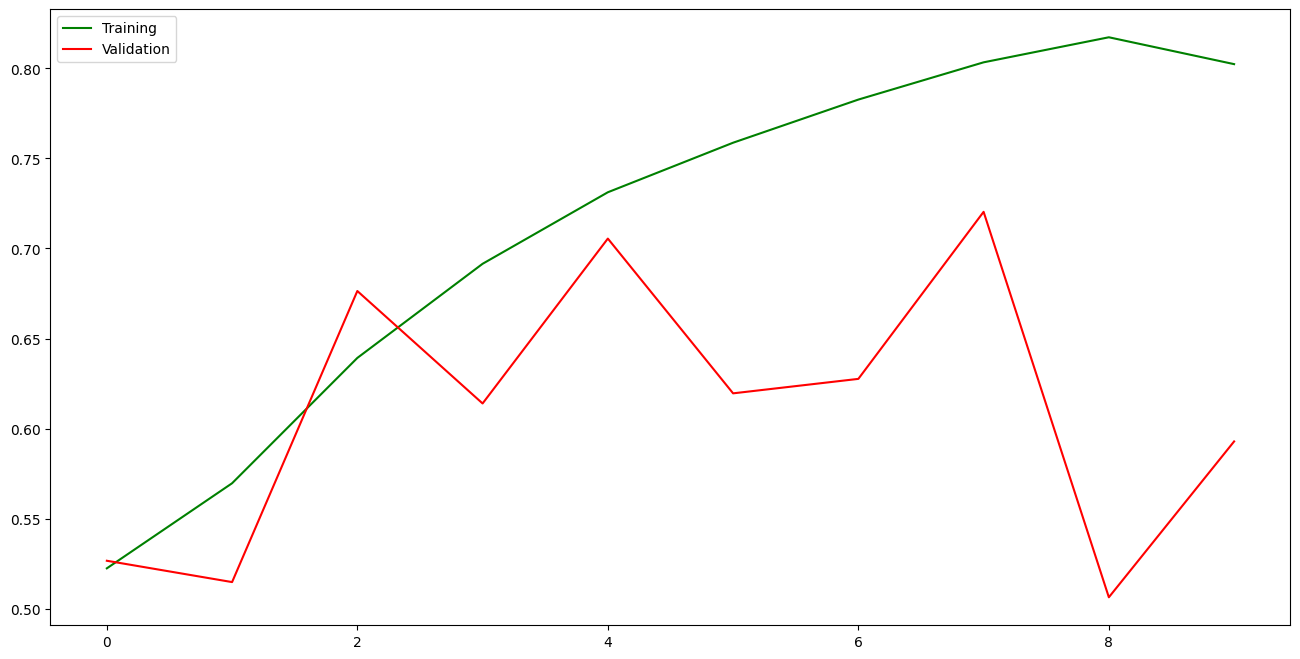

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(history0.history["accuracy"],color="green",label="Training")
plt.plot(history0.history["val_accuracy"],color="red",label="Validation")
plt.legend()
plt.show()

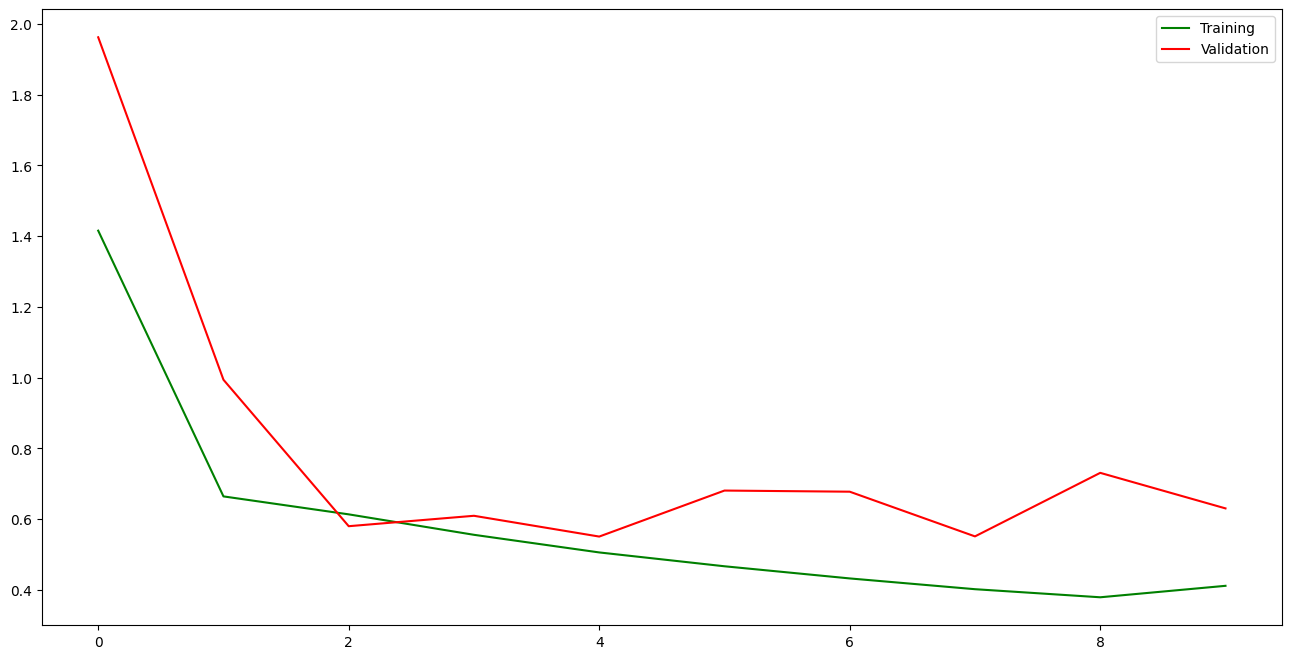

In [62]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(history0.history["loss"],color="green",label="Training")
plt.plot(history0.history["val_loss"],color="red",label="Validation")
plt.legend()
plt.show()

#7- Testing with New input

In [53]:
import cv2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


array([[0.]], dtype=float32)

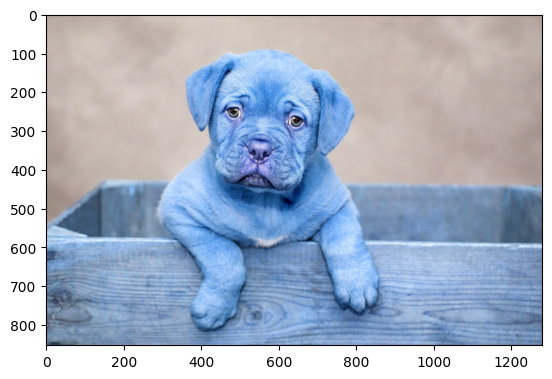

In [63]:
test_input = cv2.imread("/content/puppy-1047521_1280.jpg")
plt.imshow(test_input)
test_input = cv2.resize(test_input,(256,256))
test_input = test_input.reshape(1,256,256,3)
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


array([[0.]], dtype=float32)

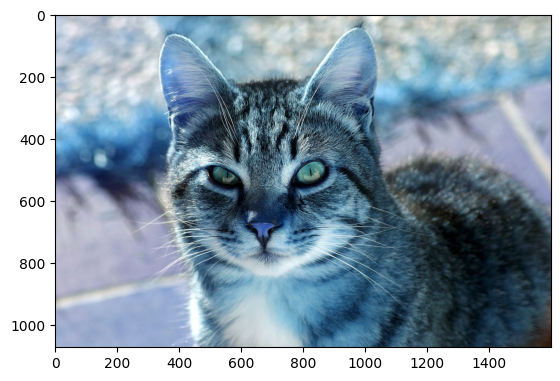

In [64]:
test_input1 = cv2.imread("/content/A-Cat.jpg")
plt.imshow(test_input1)
test_input1 = cv2.resize(test_input1,(256,256))
test_input1 = test_input1.reshape(1,256,256,3)

model.predict(test_input1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([[0.3795123]], dtype=float32)

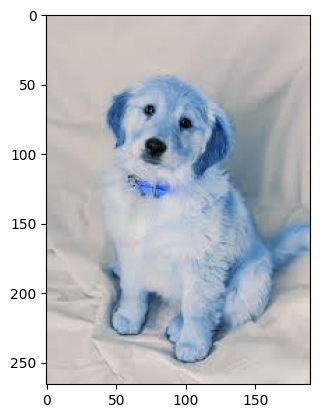

In [67]:
import cv2
img_input1 = cv2.imread("/content/images-2.jpeg")
plt.imshow(img_input1)

img_input1 = cv2.resize(img_input1,(256,256))
img_input1 = img_input1.reshape(1,256,256,3)
model.predict(img_input1)

# Observation
1) - Using simple CNN model we were only able to achieve 80percent training acccuracy and 60 percent validation accuracy clearly showing there is some overfitting in model

2)-Overfitting here means model not learning the actual pattern like primitve feature combination of edges and memorizing it more due to why its giving less accuracy when we put it to validation testing


#Solution
1) In order to reduce overfitting we can use Data Augmentation which is a technique of generating large and diverse data by creating the variations of original dataset thus helping model to learn different features of the class rather than memorising general pattern

2) We can use Transfer lerning where we can use the pretrained model such as VGG16,ResNet which are trained on Imagenet of dataset 1.6million images.IN transfer learning we usually take the Convolutional base on CNN and freeze it and use our own dense layer to make further classification

# Using Transfer Learning with Data Augementation

1-Transfer Learning - It is a technique used to store knowledge like patterns while training one model and using that same knowledge to different but related problem

2-Augementation:It is a technique used in deep learning to automatically expand the size and diversity of data or images by crearting modified version of datset(including rotation,distortion,flipping,changing brightness,Zooming,color jitter) thus helping model learn generalising paterns and stop overfitting

#1- Importing Libraries

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

#2- Making a Generator

In [ ]:
train_gen = ImageDataGenerator(
     rescale = 1./255,   #normalise the value to [0,1]
     rotation_range=30,   # randomly rotate the image
     shear_range=0.2,     # randomly distort the image
     horizontal_flip = True,  # randomly flip the image horizontally
     zoom_range = 0.2,      # randomly zoon image little more
    fill_mode="nearest"  # fill the space evenly after transformation
)

test_gen = ImageDataGenerator(rescale = 1./255)

train1 = train_gen.flow_from_directory(
    directory = "/content/data1/train",
    batch_size=16,
    target_size=(256,256),
    class_mode="binary"
)



val1= test_gen.flow_from_directory(
    directory = "/content/data1/val",
    batch_size=16,
    target_size=(256,256),
    class_mode="binary"
)

Found 19918 images belonging to 2 classes.
Found 4981 images belonging to 2 classes.


#3- Making Model

In [ ]:
conv_base = VGG16(
         weights = "imagenet",
         include_top = False,
         input_shape = (256,256,3))


conv_base.trainable=False

import tensorflow as tf
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from tensorflow.keras.models import Sequential


model1 = Sequential()
model1.add(conv_base)
model1.add(Flatten())


model1.add(Dense(128,activation="relu"))
model1.add(Dropout(0.2))
model1.add(Dense(64,activation ="relu"))
model1.add(Dense(1,activation="sigmoid"))



model1.compile(loss="binary_crossentropy",optimizer = "adam",metrics=["accuracy"])
history = model1.fit(train1,epochs=10,steps_per_epoch = 100,validation_data=val1,validation_steps=20)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 68s 647ms/step - accuracy: 0.7077 - loss: 0.6613 - val_accuracy: 0.8906 - val_loss: 0.2565
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 818ms/step - accuracy: 0.8763 - loss: 0.2816 - val_accuracy: 0.9109 - val_loss: 0.2130
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 824ms/step - accuracy: 0.9007 - loss: 0.2286 - val_accuracy: 0.9281 - val_loss: 0.1843
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 826ms/step - accuracy: 0.8993 - loss: 0.2260 - val_accuracy: 0.9312 - val_loss: 0.1771
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 68s 689ms/step - accuracy: 0.9046 - loss: 0.2183 - val_accuracy: 0.9250 - val_loss: 0.1979
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 821ms/step - accuracy: 0.9018 - loss: 0.2354 - val_accuracy: 0.9422 - val_loss: 0.1702
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 206ms/step - accuracy: 0.9218 - loss: 0.1855 - val_accuracy: 0.9172 - val_loss: 0.1742
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9199 - loss: 0.2

# 4-Evaluating the Model

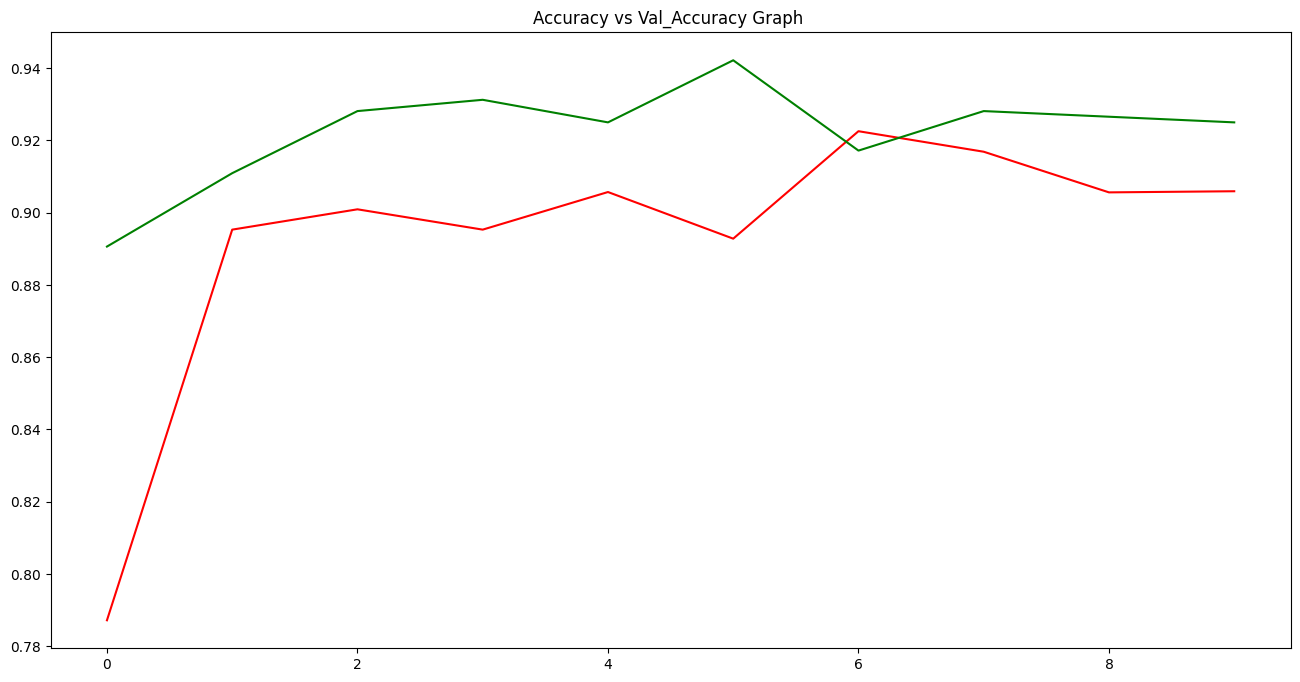

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(history.history["accuracy"],label="Accuracy",color="red")
plt.plot(history.history["val_accuracy"],label="Val_accuracy",color="green")
plt.title("Accuracy vs Val_Accuracy Graph ")
plt.show()

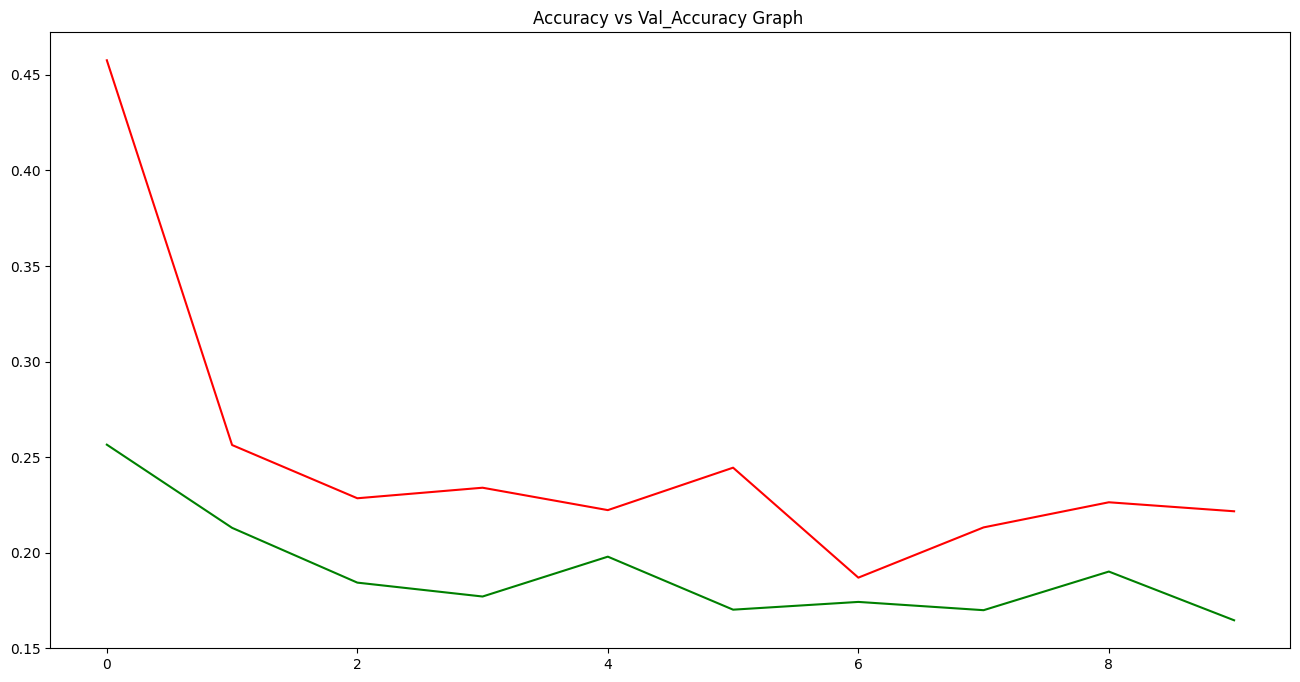

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(history.history["loss"],label="Accuracy",color="red")
plt.plot(history.history["val_loss"],label="Val_accuracy",color="green")
plt.title("Accuracy vs Val_Accuracy Graph ")
plt.show()

#5-Testing model on New Input

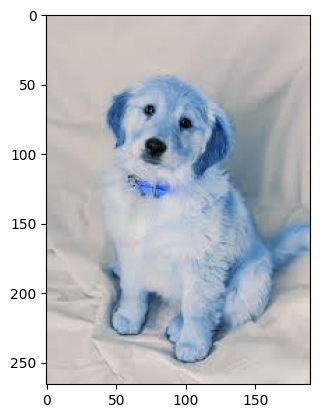

In [ ]:
import cv2
img_input1 = cv2.imread("/content/images-2.jpeg")
plt.imshow(img_input1)

In [ ]:
img_input1 = cv2.resize(img_input1,(256,256))
img_input1 = img_input1.reshape(1,256,256,3)
model1.predict(img_input1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[1.]], dtype=float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


array([[1.]], dtype=float32)

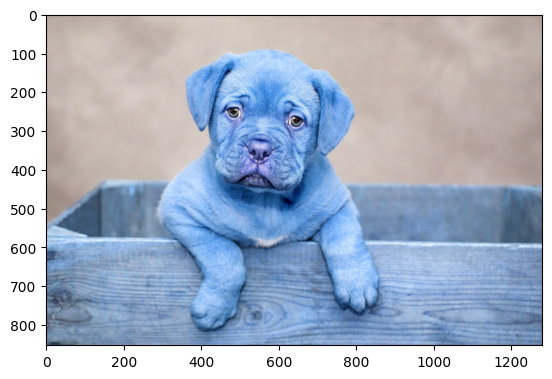

In [57]:
test_input = cv2.imread("/content/puppy-1047521_1280.jpg")
plt.imshow(test_input)
test_input = cv2.resize(test_input,(256,256))
test_input = test_input.reshape(1,256,256,3)
model1.predict(test_input)

#Observation and Result-:
1)- From above graphs we can clearly see that when we using Transfer learning with Data Augementation our training accuracy increased to  92% and validation accuracy is also near 92% showing that there is almost no overfittig in the model

2) Apart from that Validation accuracy is 92% which is 30% better than normal CNN model thus showing that its also performing much more better in learning generalising patterns.

3)Also when we testing with new input Our new model able to guess dog vs Cat better as compare to normal CNN